In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [5]:
## update data
def filter_df(df):
    max=39
    n=16
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    df = df.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
data_all = data_all.query('age<16')

In [7]:
# filter data to make sure only ages from both dataset appear in subsequent analysis
mask = data.index.get_level_values('age').intersection(data_dana.index.get_level_values('age'))
fdata = data[data.index.get_level_values('age').isin(mask)]
fdata_dana = data_dana[data_dana.index.get_level_values('age').isin(mask)]
fdata_all = pd.concat([fdata,fdata_dana])

In [8]:
## embedding fo all data

In [9]:
#umap
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [10]:
data_umap = data_all.groupby(['age','uuid']).mean().copy()
exp = data_umap.index.get_level_values('age').unique().to_numpy()
data_umap_labels = data_umap.index.get_level_values('age').to_numpy()
# actual umap
coordinates = umap_embedding(data_umap.T, 
        standardize=False,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=10,
        random_state=42)

In [11]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

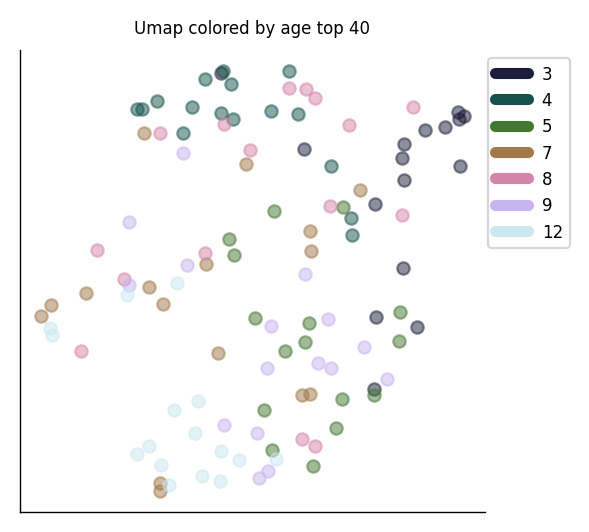

In [12]:
# plot
# prepare colors for plot
phasec = sns.color_palette("cubehelix", 7)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by age top 40',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [13]:
# color by exp

In [14]:
data_umap = data_all.groupby(['age','data','uuid']).mean().copy()
exp = data_umap.index.get_level_values('data').unique().to_numpy()
data_umap_labels = data_umap.index.get_level_values('data').to_numpy()
# actual umap
coordinates = umap_embedding(data_umap.T, 
        standardize=False,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=10,
        random_state=42)

In [15]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

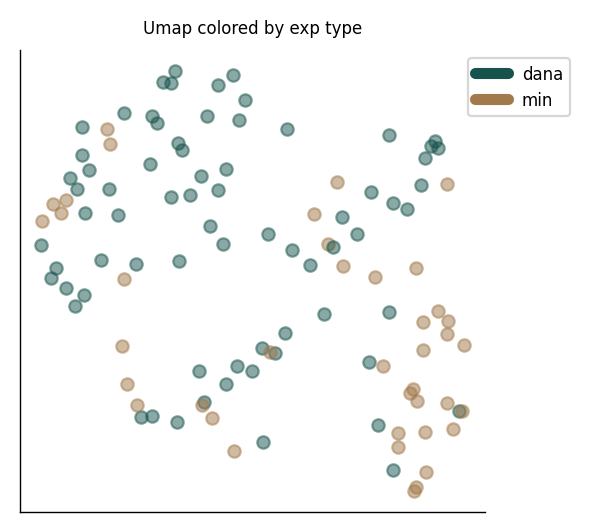

In [16]:
# plot
# prepare colors for plot
phasec = sns.color_palette("cubehelix", 3)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by exp type',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [17]:
## age classifier for combined dataset:

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [19]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    #fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [20]:
data= data_all.copy()
data_labels = data.index.get_level_values('age').to_numpy()

In [21]:
# choose a model for decoder
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 200)
#clf = LinearRegression()
#clf = LogisticRegression()
#clf = KNeighborsRegressor(n_neighbors=5)

# choose cross validation scheme
cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv=5

#number of iterations for shuffle
it=10

In [22]:
# make linear
y =data.index.get_level_values('age').to_numpy()
#X=data.to_numpy()
X=np.log(data+1e-6)

In [23]:
#decoder
y_pred = cross_val_predict(clf, X, y, cv=cv)
#r2 = r2_score(y, y_pred)
#print(r2)
acc=np.mean(np.mean(cross_val_score(clf, X, y, cv=cv)))
print(acc)

0.6964285714285714


In [24]:
#shuffle
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, X, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


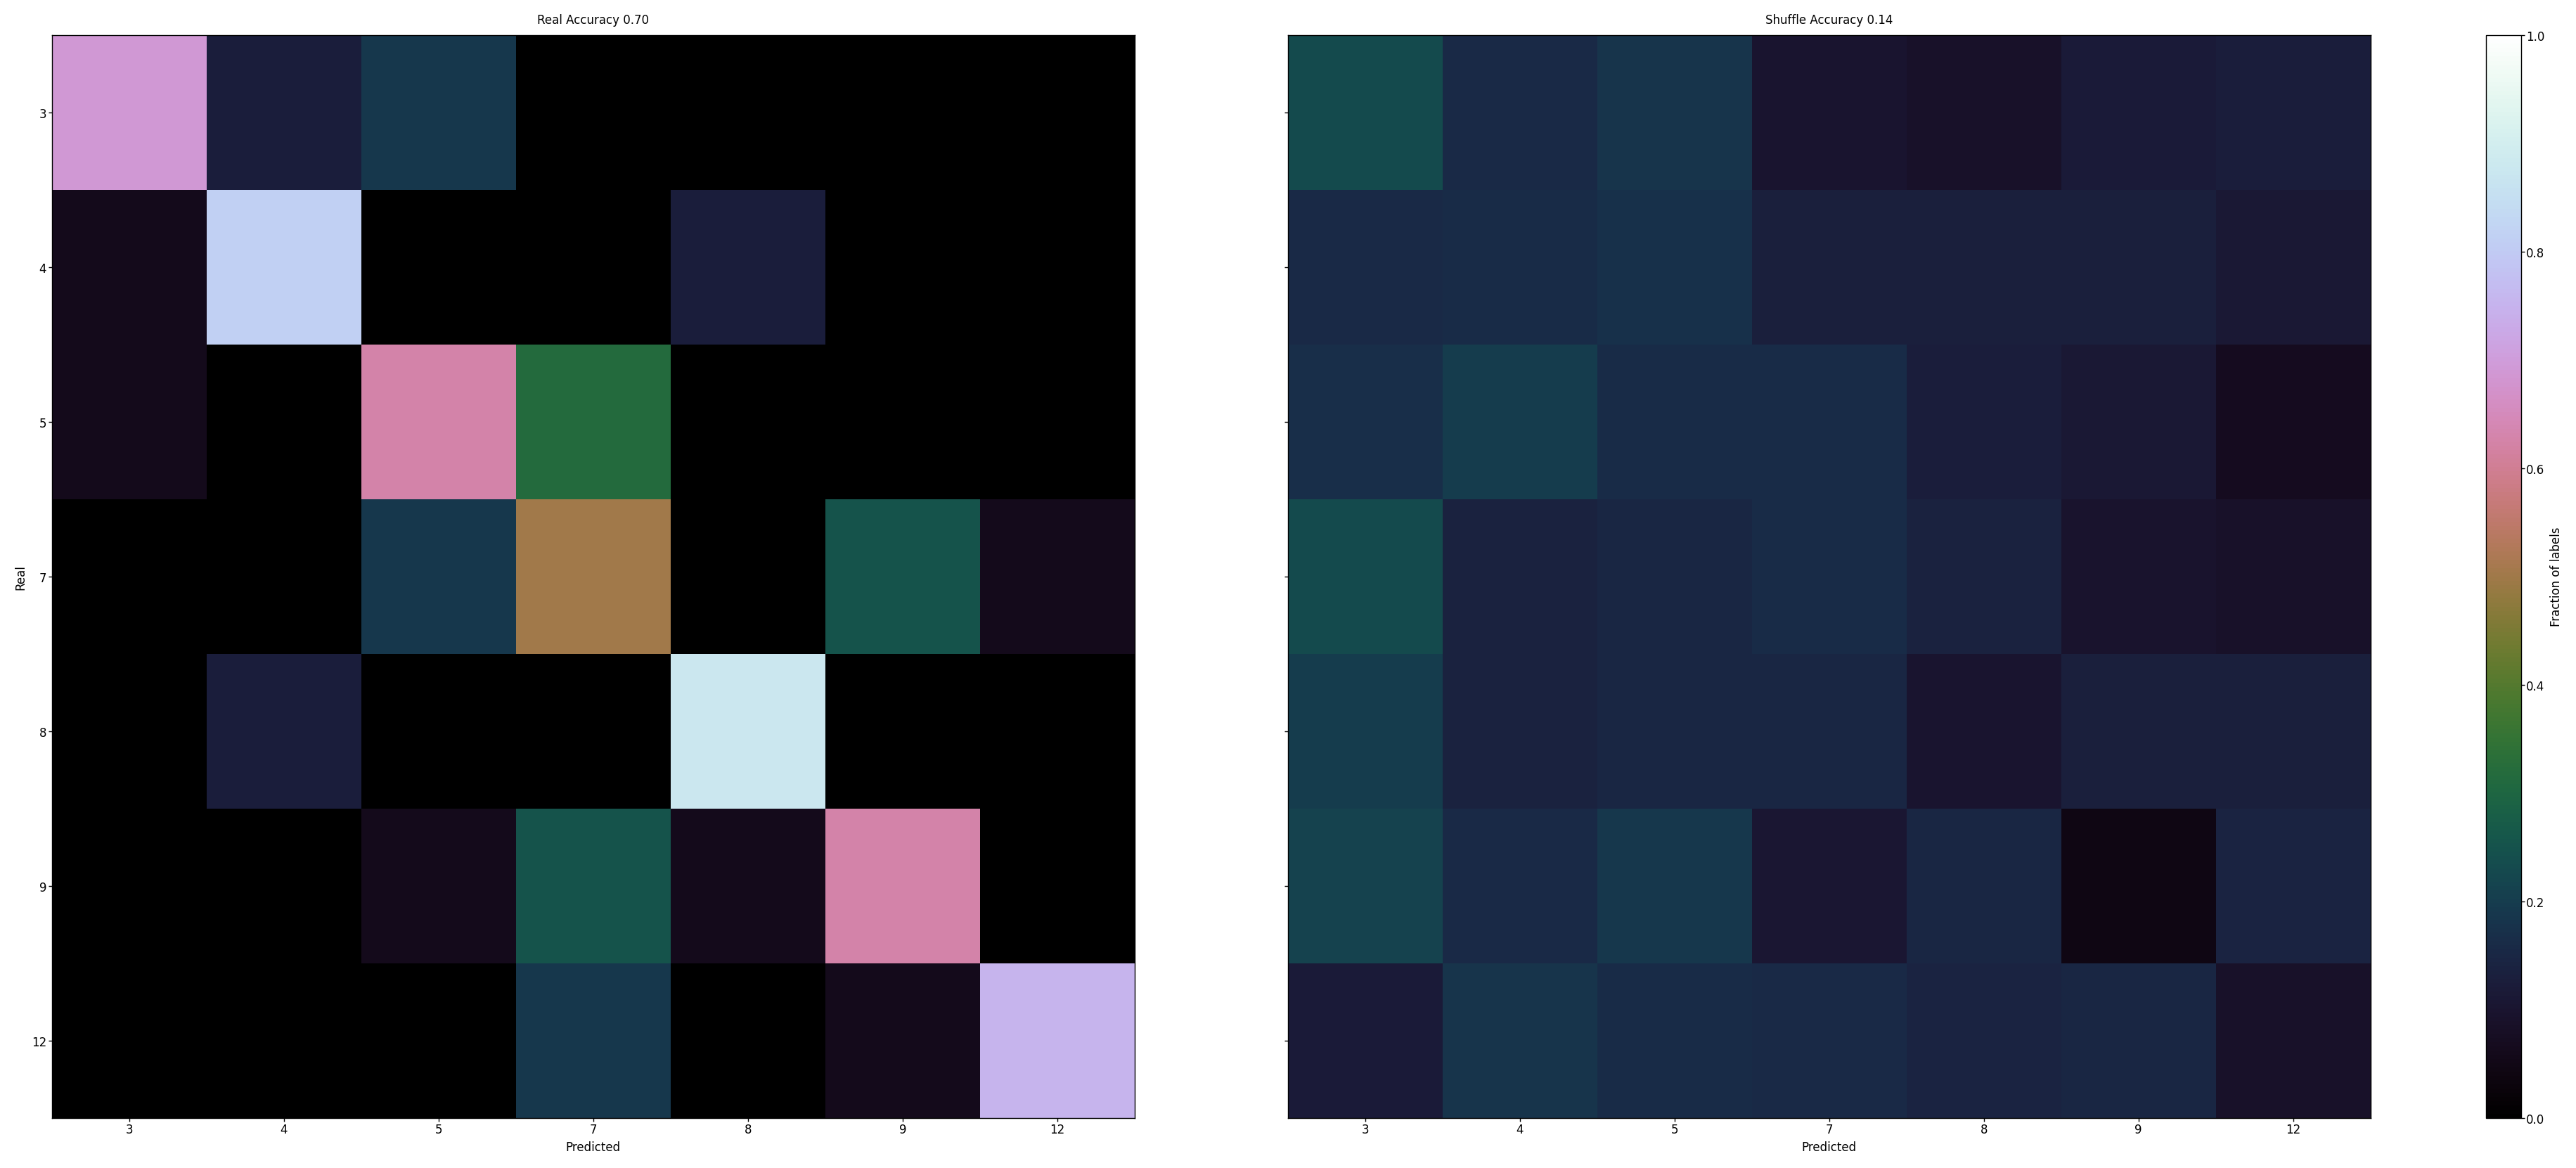

In [25]:
# plot confusion matrix
plot_cm(y,y_pred,ysh,ysh_predict)

In [26]:
## correlation matrix
from scipy.spatial.distance import pdist, squareform

In [27]:
# get JSD
fdata=data_all.copy()
kld = squareform(pdist(fdata, metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata.index.get_level_values('age').to_numpy()

In [28]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

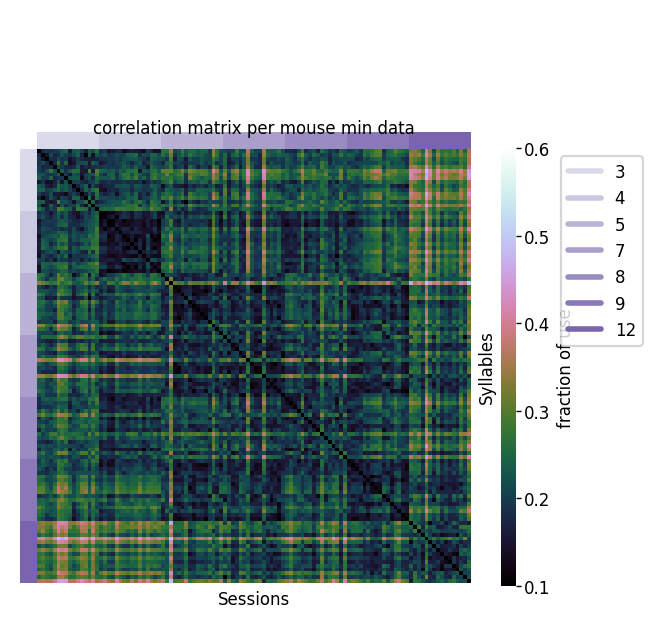

In [29]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    metric='sqeuclidean',
    #metric='cosine',
    rasterized=True,
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('correlation matrix per mouse min data')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()